In [1]:
import pickle
import numpy as np
import random
import glob
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
from torchvision.models import resnet18
from torchvision import transforms, models
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import entropy
from getData import *
from trainer import *
from getModel import *
#import torchprofile

import time
import pandas as pd
# Seed for reproducibility
SEED = 25
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

C:\Users\rafor\anaconda3\envs\endg511\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


cuda:0


# **Load Dataset**

In [4]:
dataset = TrainValDataset()
trainval_size = int(0.8 * len(dataset))
test_size = len(dataset) - trainval_size

trainval_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainval_size, test_size])

train_size = int(0.75 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size= 32, shuffle = True, num_workers= 0)

val_loader = DataLoader(val_dataset, batch_size= 32, shuffle = False, num_workers= 0)

test_loader = DataLoader(test_dataset, batch_size= 32, shuffle = False, num_workers= 0)


['Training\\Fire', 'Training\\No_Fire']


# **Baseline Model**

In [5]:
NUM_EPOCHS = 10

In [6]:
blNet = blModel().to(device)
optimizer_bl = optim.Adam(blNet.parameters(), lr=1e-3)
scheduler = None
criterion_bl = nn.CrossEntropyLoss()

In [7]:
summary(blNet, (3, 254, 254))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 254, 254]             112
       BatchNorm2d-2          [-1, 4, 254, 254]               8
              ReLU-3          [-1, 4, 254, 254]               0
            Conv2d-4          [-1, 4, 254, 254]             148
       BatchNorm2d-5          [-1, 4, 254, 254]               8
              ReLU-6          [-1, 4, 254, 254]               0
         MaxPool2d-7          [-1, 4, 127, 127]               0
            Conv2d-8          [-1, 8, 127, 127]             296
       BatchNorm2d-9          [-1, 8, 127, 127]              16
             ReLU-10          [-1, 8, 127, 127]               0
           Conv2d-11          [-1, 8, 127, 127]             584
      BatchNorm2d-12          [-1, 8, 127, 127]              16
             ReLU-13          [-1, 8, 127, 127]               0
        MaxPool2d-14            [-1, 8,

In [9]:
bl_titleToday = "./Models/best_bl_0319.pth"
BL = blHandler(blNet, criterion_bl, optimizer_bl, device=device, scheduler=scheduler, num_epochs=NUM_EPOCHS, bestPath=bl_titleToday)
blNet, blHistory = BL.train(train_loader, test_loader)

epoch 1 --> trainLoss: 0.330, trainAcc: 0.983, validLoss: 0.328, validAcc: 0.985
Model Saved!
epoch 2 --> trainLoss: 0.330, trainAcc: 0.983, validLoss: 0.325, validAcc: 0.988
Model Saved!
epoch 3 --> trainLoss: 0.325, trainAcc: 0.988, validLoss: 0.321, validAcc: 0.992
Model Saved!
epoch 4 --> trainLoss: 0.325, trainAcc: 0.988, validLoss: 0.320, validAcc: 0.993
Model Saved!
epoch 5 --> trainLoss: 0.322, trainAcc: 0.991, validLoss: 0.322, validAcc: 0.991
epoch 6 --> trainLoss: 0.323, trainAcc: 0.990, validLoss: 0.319, validAcc: 0.995
Model Saved!
epoch 7 --> trainLoss: 0.322, trainAcc: 0.991, validLoss: 0.318, validAcc: 0.995
Model Saved!
epoch 8 --> trainLoss: 0.321, trainAcc: 0.992, validLoss: 0.318, validAcc: 0.995
Model Saved!
epoch 9 --> trainLoss: 0.321, trainAcc: 0.992, validLoss: 0.319, validAcc: 0.994
epoch 10 --> trainLoss: 0.321, trainAcc: 0.992, validLoss: 0.319, validAcc: 0.994


In [40]:
bl_titleToday = "./Models/best_bl_0319.pth"
blNet.load_state_dict(torch.load("./Models/best_bl_0319.pth"))
BL = blHandler(blNet, criterion_bl, optimizer_bl, device=device, scheduler=scheduler, num_epochs=NUM_EPOCHS, bestPath=bl_titleToday)
startTime = time.time()
predicted, acc = BL.infer(test_loader)
executionTime= (time.time() - startTime)/len(predicted)

In [41]:
print(acc)
print(executionTime)

0.9945833333333334
0.0015318647798541586


# **EE Model**

In [12]:
dataset = TrainValDataset()
trainval_size = int(0.8 * len(dataset))
test_size = len(dataset) - trainval_size

trainval_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainval_size, test_size])

train_size = int(0.75 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size= 32, shuffle = True, num_workers= 0)

val_loader = DataLoader(val_dataset, batch_size= 32, shuffle = False, num_workers= 0)

test_loader = DataLoader(test_dataset, batch_size= 32, shuffle = False, num_workers= 0)

['Training\\Fire', 'Training\\No_Fire']


In [13]:
NUM_EPOCHS = 10

In [14]:
eeNet_V0 = eeModel_V0().to(device)
optimizer_ee_V0 = optim.Adam(eeNet_V0.parameters(), lr=1e-3)
scheduler_V0 = None
criterion_ee_V0 = nn.CrossEntropyLoss()
V0_titleToday = "./Models/best_eev0.pth"
EE_V0 = eeHandler(eeNet_V0, criterion_ee_V0, optimizer_ee_V0, device=device, scheduler=scheduler_V0, num_epochs=NUM_EPOCHS, bestPath=V0_titleToday)

Number of base parameters: 1188
Number of short branch parameters: 8402434
Number of long branch parameters: 16280850
Difference = 7878416


In [15]:
eeNetV0, eeV0History = EE_V0.train(train_loader, test_loader)

epoch 1 --> trainLoss: 0.371, trainAcc: 0.941, validLoss: 0.351, validAcc: 0.961
Model Saved!
epoch 2 --> trainLoss: 0.346, trainAcc: 0.966, validLoss: 0.334, validAcc: 0.979
Model Saved!
epoch 3 --> trainLoss: 0.339, trainAcc: 0.974, validLoss: 0.328, validAcc: 0.984
Model Saved!
epoch 4 --> trainLoss: 0.330, trainAcc: 0.982, validLoss: 0.323, validAcc: 0.990
Model Saved!
epoch 5 --> trainLoss: 0.327, trainAcc: 0.986, validLoss: 0.323, validAcc: 0.990
epoch 6 --> trainLoss: 0.326, trainAcc: 0.987, validLoss: 0.322, validAcc: 0.991
Model Saved!
epoch 7 --> trainLoss: 0.324, trainAcc: 0.989, validLoss: 0.320, validAcc: 0.993
Model Saved!
epoch 8 --> trainLoss: 0.324, trainAcc: 0.989, validLoss: 0.323, validAcc: 0.990
epoch 9 --> trainLoss: 0.323, trainAcc: 0.990, validLoss: 0.320, validAcc: 0.994
Model Saved!
epoch 10 --> trainLoss: 0.322, trainAcc: 0.991, validLoss: 0.320, validAcc: 0.993


In [16]:
V0_titleToday = "./Models/best_eev0.pth"
eeNet_V0.load_state_dict(torch.load("./Models/best_eev0.pth"))
EE_V0 = eeHandler(eeNet_V0, criterion_ee_V0, optimizer_ee_V0, device=device, scheduler=scheduler_V0, num_epochs=NUM_EPOCHS, bestPath=V0_titleToday)

Threshold = 0.05

In [20]:
rec, pred1, acc = EE_V0.infer(test_loader, threshold = 0.05)
EE_V0.testingSummary(rec)

Summary
Branch 1: Accuracy 99.56% with 99.52% of the samples
Branch 2: Accuracy 78.26% with 0.48% of the samples
Overall Weighted Accuracy: 99.46%


In [23]:
startTime = time.time()
EE_V0.forward_timeTest(test_loader, ratio = 0.9952)
executionTime= (time.time() - startTime)/len(test_dataset)
print(executionTime)

0.0012545004426495385


Threshold = 0.1

In [21]:
rec, pred2, acc = EE_V0.infer(test_loader, threshold = 0.1)
EE_V0.testingSummary(rec)

Summary
Branch 1: Accuracy 99.54% with 99.62% of the samples
Branch 2: Accuracy 77.78% with 0.38% of the samples
Overall Weighted Accuracy: 99.46%


In [24]:
startTime = time.time()
EE_V0.forward_timeTest(test_loader, ratio = 0.9962)
executionTime= (time.time() - startTime)/len(test_dataset)
print(executionTime)

0.001204554022991579


Threshold = 0.2

In [22]:
rec, pred3, acc = EE_V0.infer(test_loader, threshold = 0.2)
EE_V0.testingSummary(rec)

Summary
Branch 1: Accuracy 99.50% with 99.74% of the samples
Branch 2: Accuracy 76.00% with 0.26% of the samples
Overall Weighted Accuracy: 99.44%


In [25]:
startTime = time.time()
EE_V0.forward_timeTest(test_loader, ratio = 0.9974)
executionTime= (time.time() - startTime)/len(test_dataset)
print(executionTime)

0.0012272853058494


In [26]:
eeNet_V0.compute_size()

94.18785858154297

# **Plots**

In [27]:
idx = range(len(test_dataset))
true_label = []
for inputs, labels in test_loader:
        
        labels = labels.data.cpu().float().tolist()
        true_label.extend(labels) # Save Truth


In [28]:
for i in range(len(true_label)):
    true_label[i] = int(true_label[i][0])

**BL Plots**

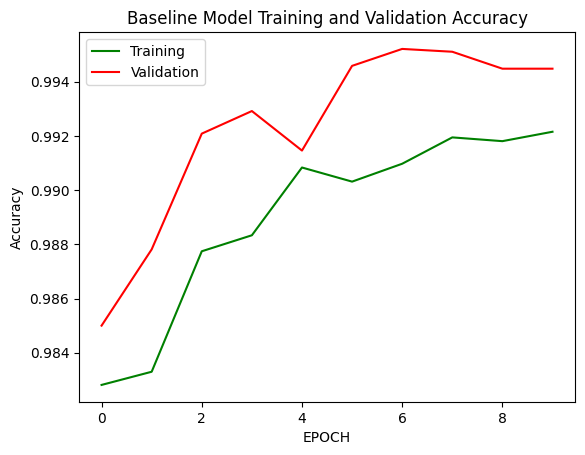

In [29]:
figTitle = './Figures/BL_tv_acc.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, blHistory["train"]["accuracy"], color = "green");
plt.plot(xAxis, blHistory["validation"]["accuracy"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.title("Baseline Model Training and Validation Accuracy")
plt.savefig(figTitle)
plt.show()

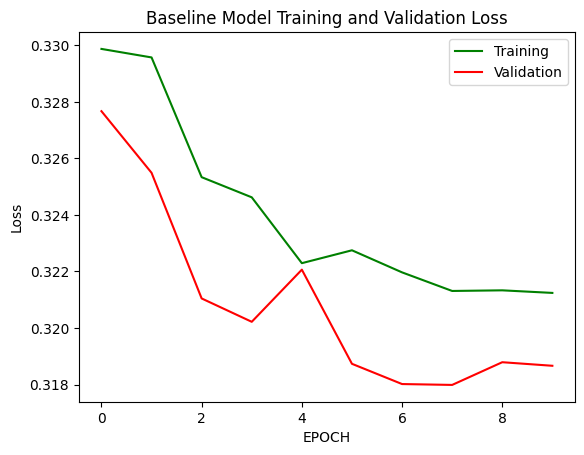

In [30]:
figTitle = './Figures/BL_tv_loss.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, blHistory["train"]["loss"], color = "green");
plt.plot(xAxis, blHistory["validation"]["loss"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title("Baseline Model Training and Validation Loss")
plt.savefig(figTitle)
plt.show()

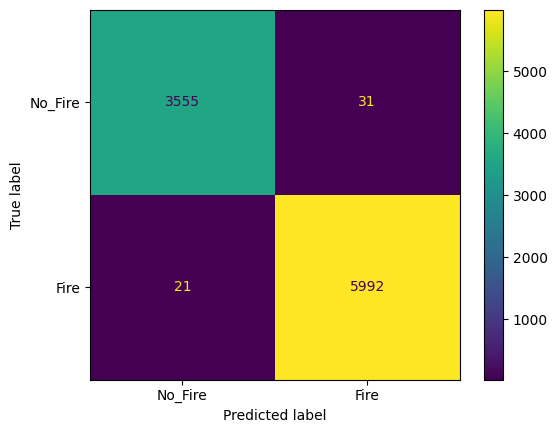

In [42]:
cfm = confusion_matrix(true_label, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()

**Early Exiting Plots**

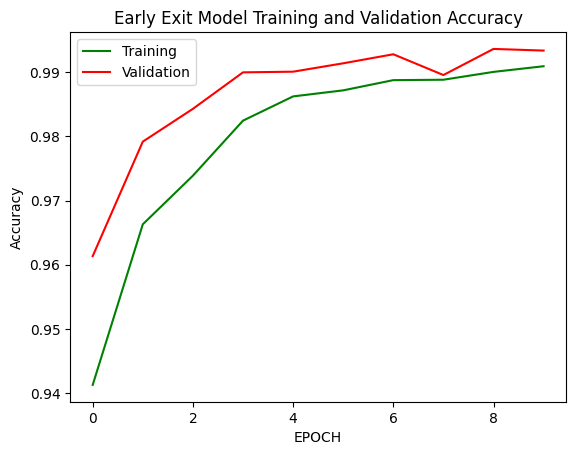

In [36]:
figTitle = './Figures/EE0_tv_acc.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, eeV0History['T']["train"]["accuracy"], color = "green");
plt.plot(xAxis, eeV0History['T']["validation"]["accuracy"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.title("Early Exit Model Training and Validation Accuracy")
plt.savefig(figTitle)
plt.show()

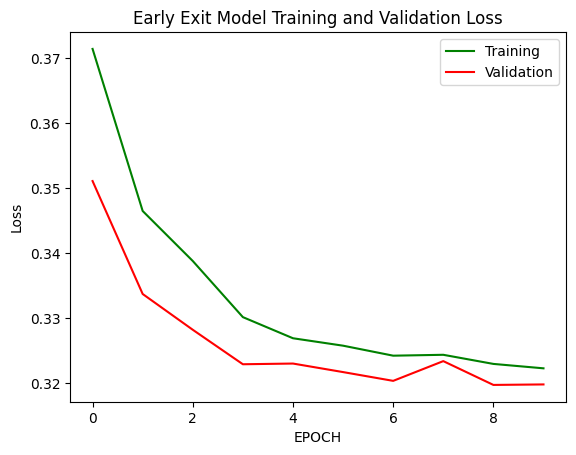

In [37]:
figTitle = './Figures/EE0_tv_loss.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, eeV0History['T']["train"]["loss"], color = "green");
plt.plot(xAxis, eeV0History['T']["validation"]["loss"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title("Early Exit Model Training and Validation Loss")
plt.savefig(figTitle)
plt.show()

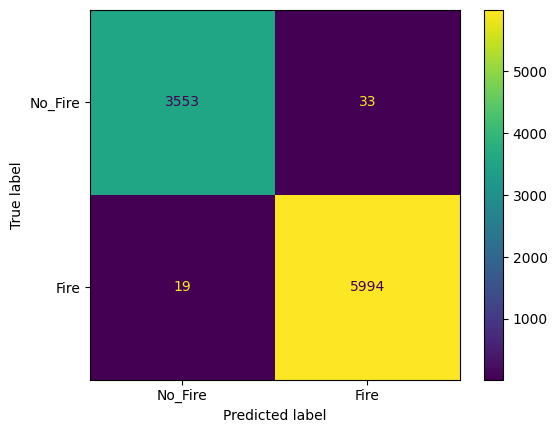

In [32]:
cfm = confusion_matrix(true_label, pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()

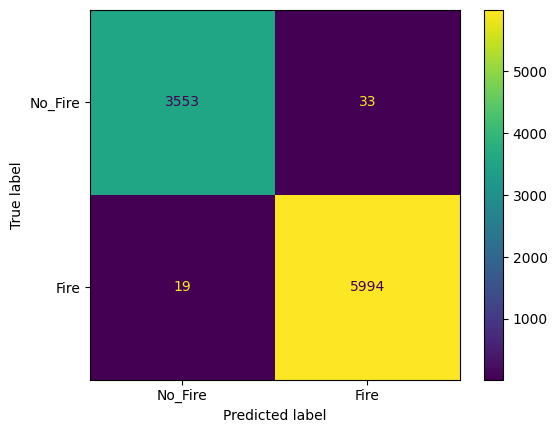

In [34]:
cfm = confusion_matrix(true_label, pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()

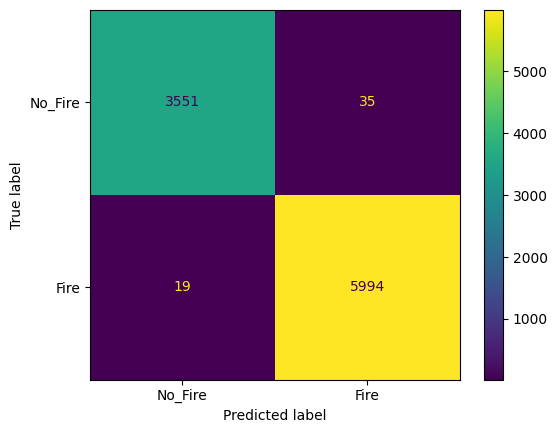

In [35]:
cfm = confusion_matrix(true_label, pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()